# 딥러닝 심화 과제2 RNN 응용 - 혐오표현 분류

In [2]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, Attention, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, accuracy_score, classification_report

In [3]:
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

### 데이터 로드

In [4]:
train_df = pd.read_parquet('./hate_speech_dataset/train.parquet')
validation_df = pd.read_parquet('./hate_speech_dataset/validation.parquet')
test_df = pd.read_parquet('./hate_speech_dataset/test.parquet')

In [5]:
print("--- 데이터 크기 확인 ---")
print(f"Train: {train_df.shape}, Validation: {validation_df.shape}, Test: {test_df.shape}")

--- 데이터 크기 확인 ---
Train: (78977, 2), Validation: (8776, 2), Test: (21939, 2)


In [6]:
print("\n--- Train 데이터 샘플 (처음 10줄) ---")
display(train_df.head(10))


--- Train 데이터 샘플 (처음 10줄) ---


,text,label
0,"""자한당틀딱들.. 악플질 고만해라.""","[2, 4]"
1,정치적으로 편향된 평론한은 분은 별로...,[8]
2,적당히좀 쳐먹지.그랬냐??? 안그래도 문재인 때문에 나라 엉망진창인데...,[2]
3,"""안서는 아재들 풀발기 ㅋㄲㅋ""",[4]
4,우와 ㅋ 능력자,[8]
5,맛녀석 콩트보다 약했음맛녀석 애청자로써 70%실력발휘,[8]
6,주영훈 솔직히 호감임 잉꼬부부로 소문났잖아,[8]
7,이게주간아이돌이랑머가달라...,[8]
8,아오 슈박 회사생활도 졑깥고 돈벌기 힘들어 죽겠구만 뭔 저딴것들 자꾸 tv나와서 사...,[3]
9,"""문재인 하는게 뭐 별거있냐?ㅂㅅㅅㅋ가 하는짓인데 어련하겠어.ㅋㅋㅋ""","[2, 3]"


### 결측치 처리 

In [7]:
print("\n--- 결측치 확인 ---")
print("Train Nulls:\n", train_df.isnull().sum())
print("\nValidation Nulls:\n", validation_df.isnull().sum())
print("\nTest Nulls:\n", test_df.isnull().sum())


--- 결측치 확인 ---
Train Nulls:
 text     0
label    0
dtype: int64

Validation Nulls:
 text     0
label    0
dtype: int64

Test Nulls:
 text     0
label    0
dtype: int64


In [8]:
print(f"\n--- 중복 데이터 확인 및 제거 전 ---")
print(f"Train 중복 개수: {train_df.duplicated(subset=['text']).sum()}")
print(f"Validation 중복 개수: {validation_df.duplicated(subset=['text']).sum()}")
print(f"Test 중복 개수: {test_df.duplicated(subset=['text']).sum()}")


--- 중복 데이터 확인 및 제거 전 ---
Train 중복 개수: 421
Validation 중복 개수: 4
Test 중복 개수: 38


In [9]:
train_df = train_df.drop_duplicates(subset=['text']).reset_index(drop=True)
validation_df = validation_df.drop_duplicates(subset=['text']).reset_index(drop=True)
test_df = test_df.drop_duplicates(subset=['text']).reset_index(drop=True)

print(f"\n--- 중복 데이터 제거 후 ---")
print(f"Train: {train_df.shape}, Validation: {validation_df.shape}, Test: {test_df.shape}")


--- 중복 데이터 제거 후 ---
Train: (78556, 2), Validation: (8772, 2), Test: (21901, 2)


### 레이블 데이터 전처리 및 분포 시각화 

In [10]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['label'])
y_valid = mlb.transform(validation_df['label'])
y_test = mlb.transform(test_df['label'])

print("--- 변환된 레이블 샘플 (처음 5개) ---")
print(y_train[:5])
print("\nBinarizer가 학습한 클래스:", mlb.classes_)

--- 변환된 레이블 샘플 (처음 5개) ---
[[0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]]

Binarizer가 학습한 클래스: [0 1 2 3 4 5 6 7 8]


C:\Users\jocke\AppData\Local\Temp\ipykernel_19288\3562823734.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


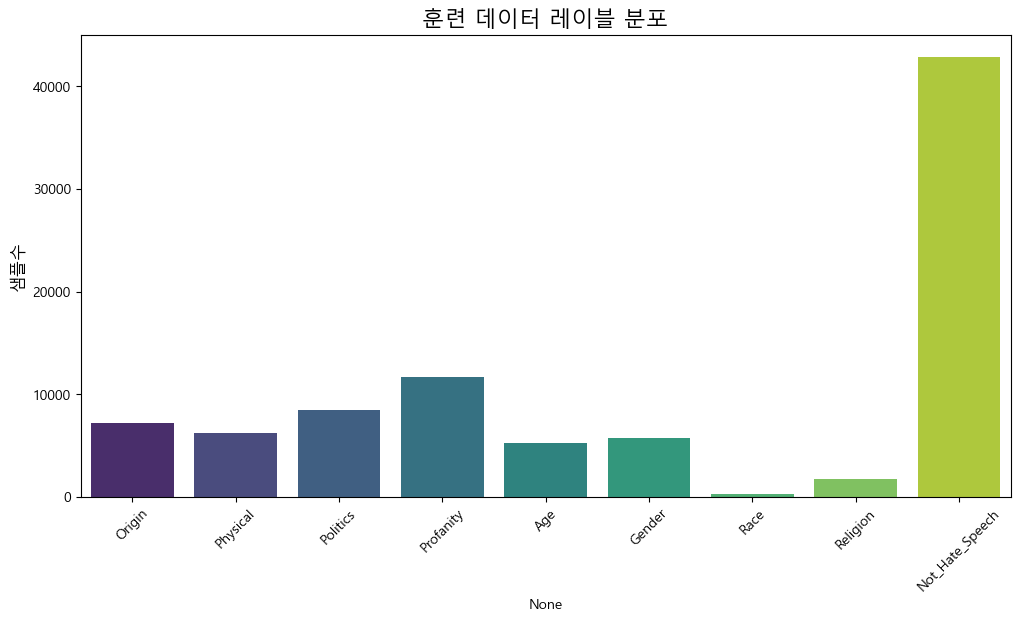

In [11]:
label_names = [
    'Origin', 'Physical', 'Politics', 'Profanity', 'Age',
    'Gender', 'Race', 'Religion', 'Not_Hate_Speech'
]
label_counts = pd.DataFrame(y_train, columns=label_names).sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('훈련 데이터 레이블 분포', fontsize=16)
plt.ylabel('샘플수', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 텍스트 데이터 전처리 (토큰화, 인코딩, 패딩)

In [12]:
def preprocess_text(text):
    text = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', text)
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
validation_df['text'] = validation_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

okt = Okt()
print("Okt 토큰화")
X_train_tokenized = [okt.morphs(sentence, stem=True) for sentence in tqdm(train_df['text'])]
X_valid_tokenized = [okt.morphs(sentence, stem=True) for sentence in tqdm(validation_df['text'])]
X_test_tokenized = [okt.morphs(sentence, stem=True) for sentence in tqdm(test_df['text'])]

print("\n--- 토큰화 결과 샘플 ---")
print(X_train_tokenized[:3])

Okt 토큰화


100%|███████████████████████████████████████████████████████████████████████████| 21901/21901 [01:42<00:00, 213.72it/s]


--- 토큰화 결과 샘플 ---
[['자', '한', '당', '틀', '딱', '들다', '악플', '질', '고만하다'], ['정치', '적', '으로', '편향', '되다', '평론', '한', '은', '분', '은', '별로'], ['적당하다', '좀', '치다', '먹다', '그렇다', '안', '그렇다', '문재인', '때문', '에', '나라', '엉망', '진창', '인데']]


In [13]:
# --- 정수 인코딩 및 희귀 단어 분석 ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_tokenized)

threshold = 4
total_cnt = len(tokenizer.word_index)
rare_cnt = sum(1 for v in tokenizer.word_counts.values() if v < threshold)
print("\n--- 단어 집합(Vocabulary) 분석 ---")
print('단어 집합의 크기 :', total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)

vocab_size = total_cnt - rare_cnt + 2
print('최종 단어 집합의 크기:', vocab_size)


--- 단어 집합(Vocabulary) 분석 ---
단어 집합의 크기 : 37127
등장 빈도가 4번 미만인 희귀 단어수: 24297
단어 집합에서 희귀 단어의 비율: 65.44293910092385
최종 단어 집합의 크기: 12832


In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(X_train_tokenized)
X_train_encoded = tokenizer.texts_to_sequences(X_train_tokenized)
X_valid_encoded = tokenizer.texts_to_sequences(X_valid_tokenized)
X_test_encoded = tokenizer.texts_to_sequences(X_test_tokenized)

print("\n--- 정수 인코딩 결과 샘플 ---")
print(X_train_encoded[:3])


--- 정수 인코딩 결과 샘플 ---
[[107, 22, 157, 56, 44, 18, 369, 371, 3586], [380, 85, 32, 9917, 19, 1, 22, 6, 254, 6, 462], [718, 40, 97, 58, 46, 25, 46, 103, 168, 7, 95, 4764, 11135, 86]]



--- 문장 길이 분포 분석 ---
최대 길이 : 137
평균 길이 : 12.67116451957839


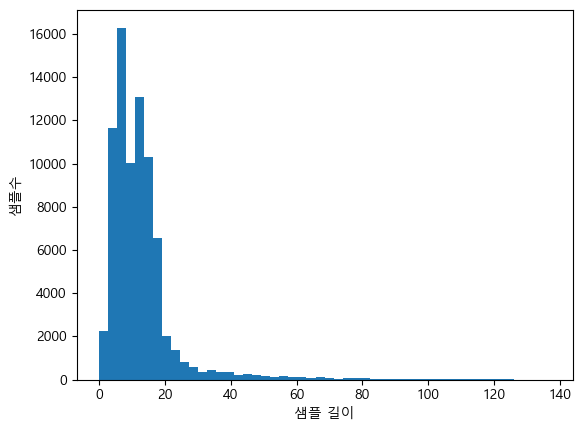

In [15]:
print('\n--- 문장 길이 분포 분석 ---')
print('최대 길이 :', max(len(l) for l in X_train_encoded))
print('평균 길이 :', sum(map(len, X_train_encoded)) / len(X_train_encoded))

plt.hist([len(s) for s in X_train_encoded], bins=50)
plt.xlabel('샘플 길이')
plt.ylabel('샘플수')
plt.show()

In [16]:
max_len = 50
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_len)
X_valid_padded = pad_sequences(X_valid_encoded, maxlen=max_len)
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_len)

print('\n--- 패딩 후 데이터 크기 ---')
print(f"X_train_padded: {X_train_padded.shape}")
print(f"X_valid_padded: {X_valid_padded.shape}")
print(f"X_test_padded: {X_test_padded.shape}")


--- 패딩 후 데이터 크기 ---
X_train_padded: (78556, 50)
X_valid_padded: (8772, 50)
X_test_padded: (21901, 50)


### 모델 설계

In [17]:
def build_best_model(vocab_size, embedding_dim=128, max_len=50, lstm_units=128):
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(vocab_size, embedding_dim)(inputs)
    bilstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
    attention_layer = Attention()([bilstm, bilstm])
    pool = GlobalMaxPooling1D()(attention_layer)
    dense1 = Dense(64, activation='relu')(pool)
    drop = Dropout(0.5)(dense1)
    outputs = Dense(y_train.shape[1], activation='sigmoid')(drop)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
model = build_best_model(vocab_size=vocab_size, max_len=max_len)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 50, 128)           │       1,642,496 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 50, 256)           │         263,168 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 50, 256)           │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ bidirectional[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 256)               │               0 │ attention[0][0]            │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │          16,448 │ global_max_pooling1d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 9)                 │             585 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,922,697 (7.33 MB)

 Trainable params: 1,922,697 (7.33 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_hate_speech_model.h5', monitor='val_loss', mode='min', save_best_only=True)

### 학습 및 손실 그래프 시각화

Epoch 1/15
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5792 - loss: 0.2725  

1228/1228 ━━━━━━━━━━━━━━━━━━━━ 163s 127ms/step - accuracy: 0.6636 - loss: 0.2133 - val_accuracy: 0.7645 - val_loss: 0.1358
Epoch 2/15
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7646 - loss: 0.1416  

1228/1228 ━━━━━━━━━━━━━━━━━━━━ 152s 124ms/step - accuracy: 0.7682 - loss: 0.1376 - val_accuracy: 0.7684 - val_loss: 0.1228
Epoch 3/15
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 203s 125ms/step - accuracy: 0.7945 - loss: 0.1164 - val_accuracy: 0.7751 - val_loss: 0.1229
Epoch 4/15
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 152s 124ms/step - accuracy: 0.8149 - loss: 0.1006 - val_accuracy: 0.7762 - val_loss: 0.1340
Epoch 5/15
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 149s 122ms/step - accuracy: 0.8321 - loss: 0.0872 - val_accuracy: 0.7685 - val_loss: 0.1416
Epoch 6/15
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 207s 125ms/step - accuracy: 0.8482 - loss: 0.0757 - val_accuracy: 0.7647 - val_loss: 0.1704
Epoch 6: early stopping


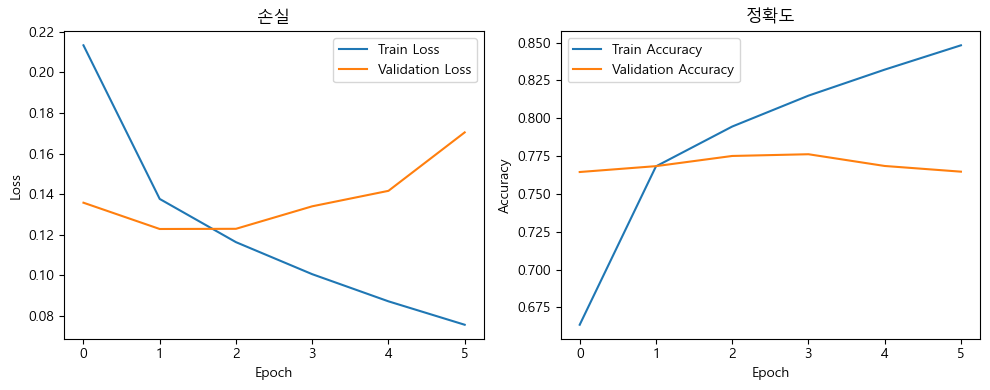

In [20]:
history = model.fit(
    X_train_padded, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_valid_padded, y_valid),
    callbacks=[es, mc]
)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('손실')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('정확도')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 모델 평가

In [21]:
loaded_model = load_model('best_hate_speech_model.h5')
y_pred_proba = loaded_model.predict(X_test_padded)
y_pred = (y_pred_proba > 0.5).astype(int)

emr = accuracy_score(y_test, y_pred)
h_loss = hamming_loss(y_test, y_pred)

print("--- 최종 평가 결과 ---")
print(f"Exact Match Ratio: {emr:.4f}")
print(f"Hamming Loss: {h_loss:.4f}")

print("\n--- 최종 평가 결과 (레이블별) ---")
report = classification_report(y_test, y_pred, target_names=label_names, zero_division=0)
print(report)

685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step
--- 최종 평가 결과 ---
Exact Match Ratio: 0.7461
Hamming Loss: 0.0465

--- 최종 평가 결과 (레이블별) ---
                 precision    recall  f1-score   support

         Origin       0.86      0.59      0.70      2159
       Physical       0.81      0.62      0.70      1740
       Politics       0.86      0.68      0.76      2453
      Profanity       0.87      0.78      0.82      3218
            Age       0.87      0.65      0.74      1479
         Gender       0.79      0.47      0.59      1573
           Race       0.00      0.00      0.00        58
       Religion       0.85      0.72      0.78       492
Not_Hate_Speech       0.85      0.90      0.87     11817

      micro avg       0.85      0.77      0.81     24989
      macro avg       0.75      0.60      0.66     24989
   weighted avg       0.85      0.77      0.80     24989
    samples avg       0.81      0.79      0.80     24989

